<a href="https://colab.research.google.com/github/OrMullerHahitti/notebooks/blob/main/Practical_4_Autoencoder_and_Variational_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders and Variational Autoencoders



In [ ]:
%matplotlib inline
!pip install torchinfo

## AutoEncoders

### Preparing the Data

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from datasets import load_dataset
import torch
torch.manual_seed(1337);

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

mnist = load_dataset("ylecun/mnist")
mnist

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [ ]:

mpl.rcParams["image.cmap"] = "gray_r"

Let's visualize some data points

(-0.5, 111.5, 27.5, -0.5)

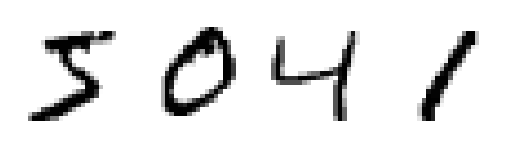

In [ ]:
im = np.array(mnist["train"]["image"][:4])  # shape (4, 28, 28)
# Combine the 4 images horizontally into a single image (28, 28*4)
combined = np.concatenate(im, axis=1)
_, ax = plt.subplots()
ax.imshow(combined, cmap="gray_r")
ax.axis("off")

In [ ]:
Note that the range of the pixel values is 0-255 (uint8). We will normalize them to 0-1 (float32) for training the autoencoder.

In [ ]:
print(im.min(), im.max())

0 255


In [ ]:
from torchvision import transforms


def mnist_to_tensor(samples):
    t = transforms.ToTensor()
    samples["image"] = [t(image) for image in samples["image"]]
    return samples

In [ ]:
mnist = mnist.with_transform(mnist_to_tensor)
mnist["train"] = mnist["train"].shuffle(seed=1337)

Let's check now that the data is properly normalized in [0,1]

In [ ]:
x = mnist["train"]["image"][0]
x.min(), x.max()

(tensor(0.), tensor(1.))

Let's define a dataloader

In [ ]:
from torch.utils.data import DataLoader

bs = 64
train_dataloader = DataLoader(mnist["train"]["image"], batch_size=bs)

### Modeling the Encoder

In [ ]:
from torch import nn


def conv_block(in_channels, out_channels, kernel_size=4, stride=2, padding=1):
    return nn.Sequential(
        nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
        ),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_channels, latent_dims=16):
        super().__init__()

        self.conv_layers = nn.Sequential(
            conv_block(in_channels, 128),
            conv_block(128, 256),
            conv_block(256, 512),
            conv_block(512, 1024),
        )
        self.linear = nn.Linear(1024, latent_dims)

    def forward(self, x):
        bs = x.shape[0]
        x = self.conv_layers(x)
        x = self.linear(x.reshape(bs, -1))
        return x

Let us create an instance of the encoder and check that it works as expected for a single data point

In [ ]:
in_channels = 1

x = mnist["train"]["image"][0][None, :]
encoder = Encoder(in_channels).eval()

encoded = encoder(x)
encoded.shape

torch.Size([1, 16])

In [ ]:
encoded

tensor([[-0.0145, -0.0318, -0.0109,  0.0080, -0.0218,  0.0305,  0.0183, -0.0294,
          0.0075,  0.0178, -0.0161, -0.0018,  0.0208, -0.0079,  0.0215,  0.0101]],
       grad_fn=<AddmmBackward0>)

Let us check now that the encoder works as expected on a batch of data

In [ ]:
batch = next(iter(train_dataloader))
encoded = Encoder(in_channels=1)(batch)
batch.shape, encoded.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64, 16]))

### Modeling the Decoder

In [ ]:
def conv_transpose_block(
    in_channels,
    out_channels,
    kernel_size=3,
    stride=2,
    padding=1,
    output_padding=0,
    with_act=True,
):
    modules = [
        nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            output_padding=output_padding,
        ),
    ]
    if with_act:  # Controling this will be handy later
        modules.append(nn.BatchNorm2d(out_channels))
        modules.append(nn.ReLU())
    return nn.Sequential(*modules)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, out_channels,latent_dims=16):
        super().__init__()

        self.linear = nn.Linear(
            latent_dims, 1024 * 4 * 4
        )  # note it's reshaped in forward
        self.t_conv1 = conv_transpose_block(1024, 512)
        self.t_conv2 = conv_transpose_block(512, 256, output_padding=1)
        self.t_conv3 = conv_transpose_block(256, out_channels, output_padding=1)

    def forward(self, x):
        bs = x.shape[0]
        x = self.linear(x)  # (bs, 1024*4*4)
        x = x.reshape((bs, 1024, 4, 4))  # (bs, 1024, 4, 4)
        x = self.t_conv1(x)  # (bs, 512, 7, 7)
        x = self.t_conv2(x)  # (bs, 256, 14, 14)
        x = self.t_conv3(x)  # (bs, 1, 28, 28)
        return x

In [ ]:
encoded.shape

torch.Size([64, 16])

In [ ]:
decoder = Decoder(in_channels)
decoded = decoder(encoded)
decoded.shape

torch.Size([64, 1, 28, 28])

### Training

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, in_channels, latent_dims=16):
        super().__init__()
        self.encoder = Encoder(in_channels, latent_dims)
        self.decoder = Decoder(in_channels, latent_dims)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        return self.decode(self.encode(x))

In [ ]:
model = AutoEncoder(1)
model.to("cpu");

In [ ]:
data=next(iter(train_dataloader))
data.shape

torch.Size([64, 1, 28, 28])

In [ ]:
model(data).shape

torch.Size([64, 1, 28, 28])

In [ ]:
import torchinfo

torchinfo.summary(model, data.shape, col_names = [ "input_size","output_size","num_params", ])


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
AutoEncoder                              [64, 1, 28, 28]           [64, 1, 28, 28]           --
├─Encoder: 1-1                           [64, 1, 28, 28]           [64, 16]                  --
│    └─Sequential: 2-1                   [64, 1, 28, 28]           [64, 1024, 1, 1]          --
│    │    └─Sequential: 3-1              [64, 1, 28, 28]           [64, 128, 14, 14]         2,432
│    │    └─Sequential: 3-2              [64, 128, 14, 14]         [64, 256, 7, 7]           525,056
│    │    └─Sequential: 3-3              [64, 256, 7, 7]           [64, 512, 3, 3]           2,098,688
│    │    └─Sequential: 3-4              [64, 512, 3, 3]           [64, 1024, 1, 1]          8,391,680
│    └─Linear: 2-2                       [64, 1024]                [64, 16]                  16,400
├─Decoder: 1-2                           [64, 16]                  [64, 1, 28, 28]           --
│    └─Li

In [ ]:
from torch.nn import functional as F
from tqdm.notebook import tqdm, trange

def train(model, num_epochs=10, lr=1e-4):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-5)

    model.train()  # Put model in training mode
    losses = []
    for _ in (progress := trange(num_epochs, desc="Training")):
        for _, batch in (
            inner := tqdm(
                enumerate(train_dataloader), total=len(train_dataloader)
            )
        ):
            batch = batch.to(device)

            # Pass through the model and obtain another set of images
            preds = model(batch)

            # Compare the prediction with the original images
            loss = F.mse_loss(preds, batch)

            # Display loss and store for plotting
            inner.set_postfix(loss=f"{loss.cpu().item():.3f}")
            losses.append(loss.item())

            # Update the model parameters with the optimizer based on this loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        progress.set_postfix(loss=f"{loss.cpu().item():.3f}", lr=f"{lr:.0e}")
    return losses

In [ ]:
model = AutoEncoder(in_channels=1, latent_dims=16)
model.to(device)
losses = train(model, lr=1e-3)

Training:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

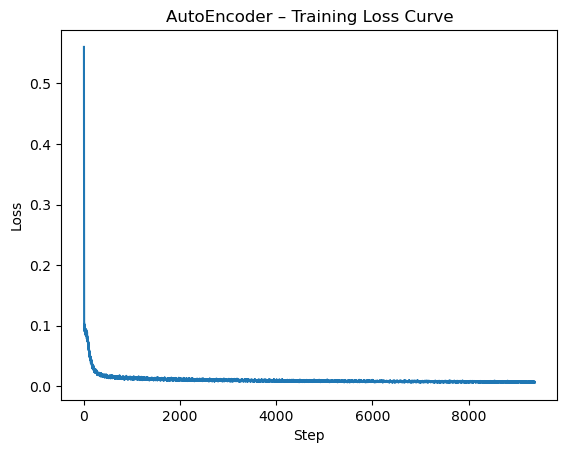

In [ ]:
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("AutoEncoder – Training Loss Curve")
plt.show()

In [ ]:
eval_bs = 16
eval_dataloader = DataLoader(mnist["test"]["image"], batch_size=eval_bs)

Let us check if the model learned to reconstruct correctly from the latent space

In [ ]:
model.eval()
with torch.inference_mode():
    eval_batch = next(iter(eval_dataloader))
    predicted = model(eval_batch.to(device)).cpu()

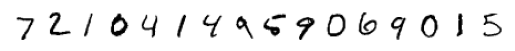

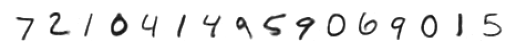

In [ ]:
def display_images(eval_batch, predicted=None):
    eval_batch = eval_batch.numpy().squeeze()
    combined_eval = np.concatenate(eval_batch, axis = 1)
    _, ax = plt.subplots()
    ax.imshow(combined_eval, cmap="gray_r")
    ax.axis("off")

    if predicted is not None:
        predicted = predicted.numpy().squeeze()
        combined_pred = np.concatenate(predicted, axis = 1)
        _, ax = plt.subplots()
        ax.imshow(combined_pred, cmap="gray_r")
        ax.axis("off")

display_images(eval_batch, predicted)

### Exploring the Latent Space in 2D


In [ ]:
ae_model = AutoEncoder(in_channels=1, latent_dims=2)
ae_model.to(device);

In [ ]:
losses = train(ae_model)

Training:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

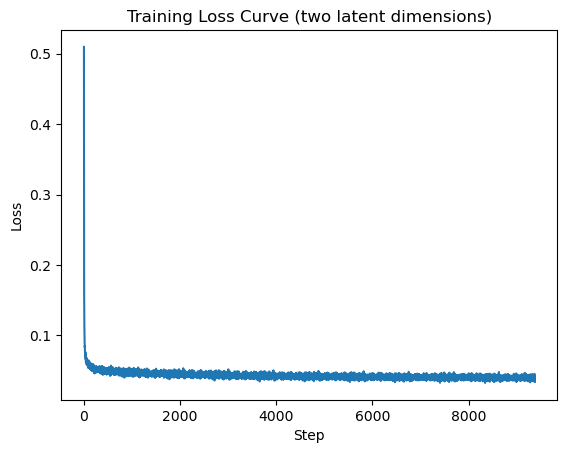

In [ ]:
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss Curve (two latent dimensions)")
plt.show()

In [ ]:
ae_model.eval()
with torch.inference_mode():
    eval_batch = next(iter(eval_dataloader))
    predicted = ae_model(eval_batch.to(device)).cpu()

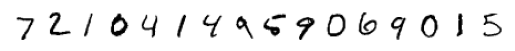

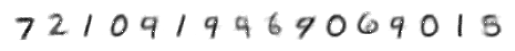

In [ ]:
display_images(eval_batch, predicted)

### Visualizing the Latent Space in 2D


In [ ]:
images_labels_dataloader = DataLoader(mnist["test"], batch_size=512)

In [ ]:
import pandas as pd

df = pd.DataFrame(
    {
        "x": [],
        "y": [],
        "label": [],
    }
)

for batch in tqdm(
    iter(images_labels_dataloader), total=len(images_labels_dataloader)
):
    encoded = ae_model.encode(batch["image"].to(device)).cpu()
    new_items = {
        "x": [t.item() for t in encoded[:, 0]],
        "y": [t.item() for t in encoded[:, 1]],
        "label": batch["label"],
    }
    df = pd.concat([df, pd.DataFrame(new_items)], ignore_index=True)

  0%|          | 0/20 [00:00<?, ?it/s]

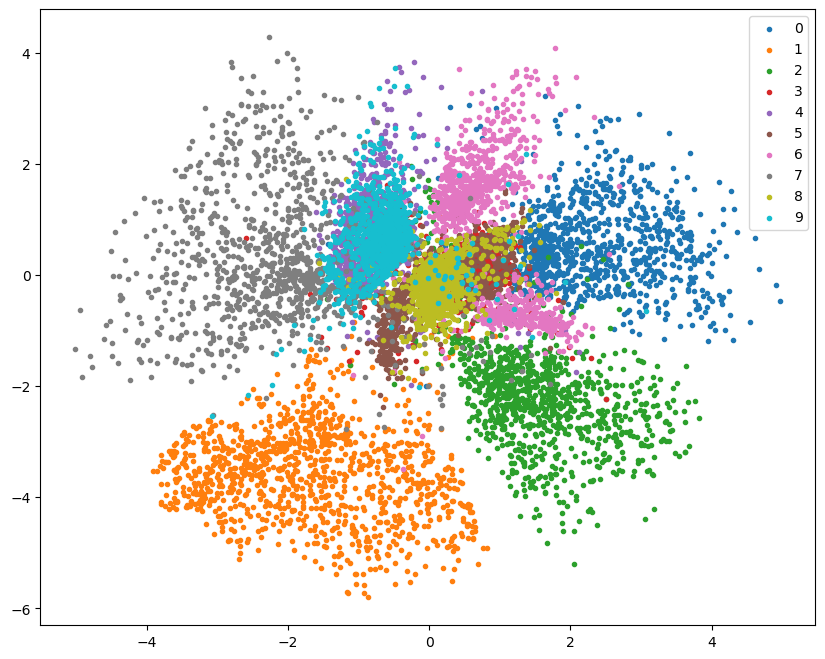

In [ ]:
plt.figure(figsize=(10, 8))

for label in range(10):
    points = df[df["label"] == label]
    plt.scatter(points["x"], points["y"], label=label, marker=".")

plt.legend();

In [ ]:
N = 16  # We'll generate 16 points
z = torch.rand((N, 2)) * 8 - 4

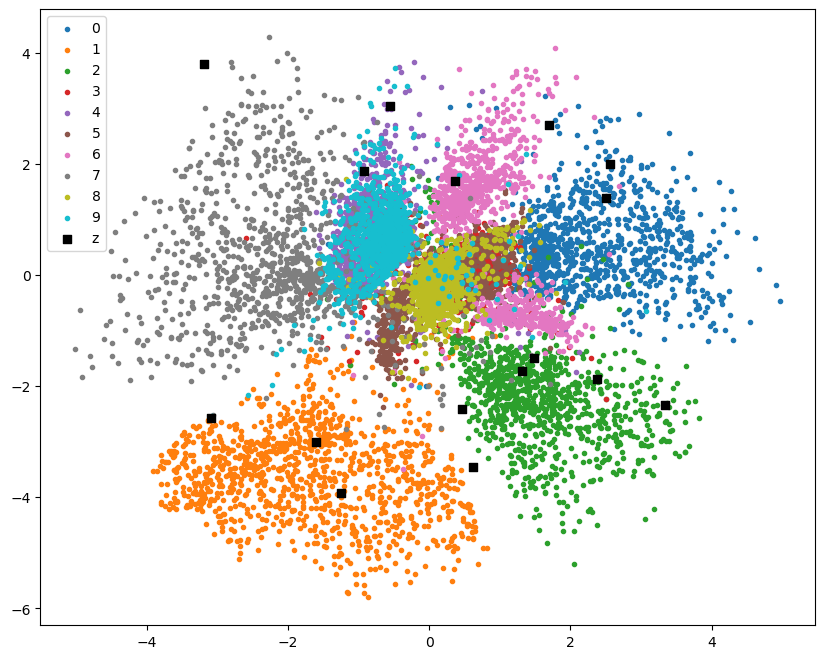

In [ ]:
plt.figure(figsize=(10, 8))

for label in range(10):
    points = df[df["label"] == label]
    plt.scatter(points["x"], points["y"], label=label, marker=".")

plt.scatter(z[:, 0], z[:, 1], label="z", marker="s", color="black")
plt.legend();

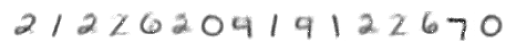

In [ ]:
ae_model.eval()

with torch.inference_mode():
    ae_decoded = ae_model.decode(z.to(device)).cpu()
display_images(ae_decoded )


## Variational AutoEncoders (VAEs)

### VAE Encoders and Decoders


In [ ]:
class VAEEncoder(nn.Module):
    def __init__(self, in_channels, latent_dims):
        super().__init__()

        self.conv_layers = nn.Sequential(
            conv_block(in_channels, 128),
            conv_block(128, 256),
            conv_block(256, 512),
            conv_block(512, 1024),
        )

        # Define fully connected layers for mean and log-variance
        self.mu = nn.Linear(1024, latent_dims)
        self.logvar = nn.Linear(1024, latent_dims)

    def forward(self, x):
        bs = x.shape[0]
        x = self.conv_layers(x)
        x = x.reshape(bs, -1)
        mu = self.mu(x)
        logvar = self.logvar(x)
        return (mu, logvar)

In [ ]:
class VAE(nn.Module):
    def __init__(self, in_channels, latent_dims):
        super().__init__()
        self.encoder = VAEEncoder(in_channels, latent_dims)
        self.decoder = Decoder(in_channels, latent_dims)

    def encode(self, x):
        # Returns mu, log_var
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        # Obtain parameters of the normal (Gaussian) distribution
        mu, logvar = self.encode(x)

        # Sample from the distribution
        std = torch.exp(0.5 * logvar)
        z = self.sample(mu, std)

        # Decode the latent point to pixel space
        reconstructed = self.decode(z)

        # Return the reconstructed image, and also the mu and logvar
        # so we can compute a distribution loss
        return reconstructed, mu, logvar

    def sample(self, mu, std):
        # Reparametrization trick
        # Sample from N(0, I), translate and scale
        eps = torch.randn_like(std)
        return mu + eps * std

### Training the VAE with 2D latents


In [ ]:
def vae_loss(batch, reconstructed, mu, logvar):
    bs = batch.shape[0]

    # Reconstruction loss from the pixels - 1 per image
    reconstruction_loss = F.mse_loss(
        reconstructed.reshape(bs, -1),
        batch.reshape(bs, -1),
        reduction="none",
    ).sum(dim=-1)

    # KL-divergence loss, per input image
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=-1)

    # Combine both losses and get the mean across images
    loss = (reconstruction_loss + kl_loss).mean(dim=0)

    return (loss, reconstruction_loss, kl_loss)

In [ ]:
def train_vae(model, num_epochs=10, lr=1e-4):
    model = model.to(device)
    losses = {
        "loss": [],
        "reconstruction_loss": [],
        "kl_loss": [],
    }

    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-5)
    for _ in (progress := trange(num_epochs, desc="Training")):
        for _, batch in (
            inner := tqdm(
                enumerate(train_dataloader), total=len(train_dataloader)
            )
        ):
            batch = batch.to(device)

            # Pass through the model
            reconstructed, mu, logvar = model(batch)

            # Compute the losses
            loss, reconstruction_loss, kl_loss = vae_loss(
                batch, reconstructed, mu, logvar
            )

            # Display loss and store for plotting
            inner.set_postfix(loss=f"{loss.cpu().item():.3f}")
            losses["loss"].append(loss.item())
            losses["reconstruction_loss"].append(
                reconstruction_loss.mean().item()
            )
            losses["kl_loss"].append(kl_loss.mean().item())

            # Update model parameters based on the total loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        progress.set_postfix(loss=f"{loss.cpu().item():.3f}", lr=f"{lr:.0e}")
    return losses

In [ ]:
vae_model = VAE(in_channels=1, latent_dims=2)

In [ ]:
losses = train_vae(vae_model, num_epochs=10, lr=1e-4)

Training:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

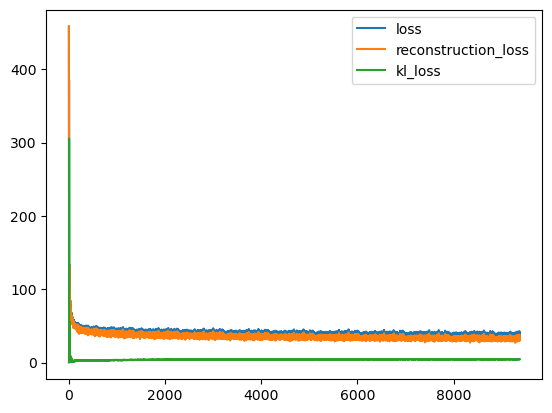

In [ ]:
for k, v in losses.items():
    plt.plot(v, label=k)
plt.legend();

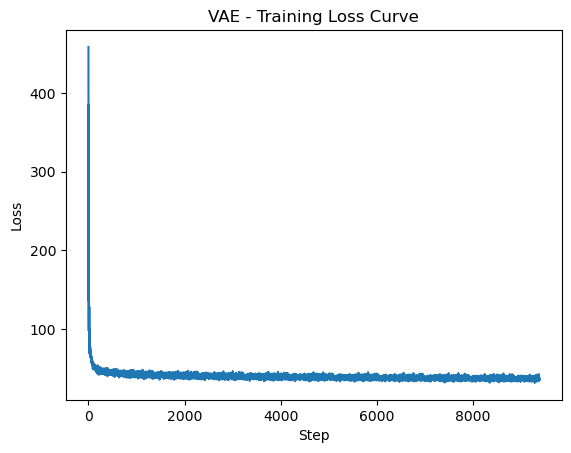

In [ ]:
plt.plot(losses["loss"])
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("VAE - Training Loss Curve")
plt.show()

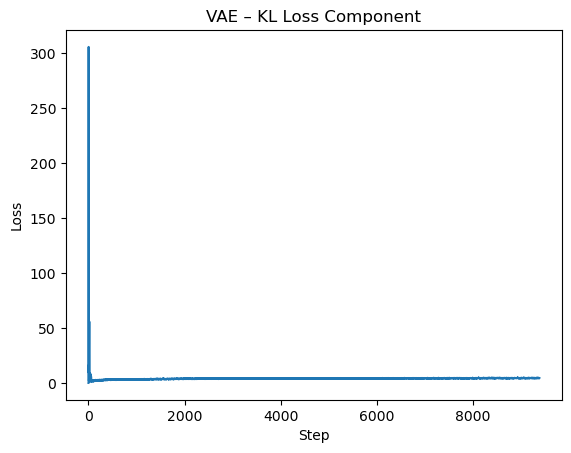

In [ ]:
plt.plot(losses["kl_loss"])
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("VAE – KL Loss Component")
plt.show()

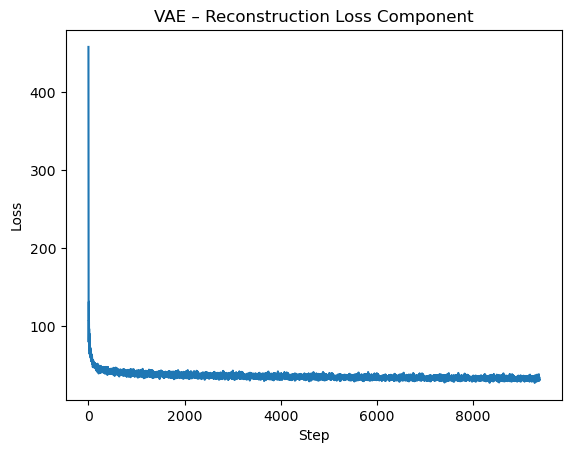

In [ ]:
plt.plot(losses["reconstruction_loss"])
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("VAE – Reconstruction Loss Component")
plt.show()

In [ ]:
vae_model.eval()
with torch.inference_mode():
    eval_batch = next(iter(eval_dataloader))
    predicted, mu, logvar = (v.cpu() for v in vae_model(eval_batch.to(device)))

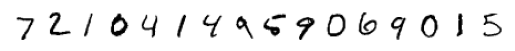

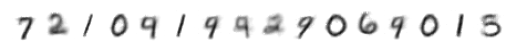

In [ ]:
display_images(eval_batch, predicted)

In [ ]:
df = pd.DataFrame(
    {
        "x": [],
        "y": [],
        "label": [],
    }
)

for batch in tqdm(
    iter(images_labels_dataloader), total=len(images_labels_dataloader)
):
    mu, _ = vae_model.encode(batch["image"].to(device))
    mu = mu.to("cpu")
    new_items = {
        "x": [t.item() for t in mu[:, 0]],
        "y": [t.item() for t in mu[:, 1]],
        "label": batch["label"],
    }
    df = pd.concat([df, pd.DataFrame(new_items)], ignore_index=True)

  0%|          | 0/20 [00:00<?, ?it/s]

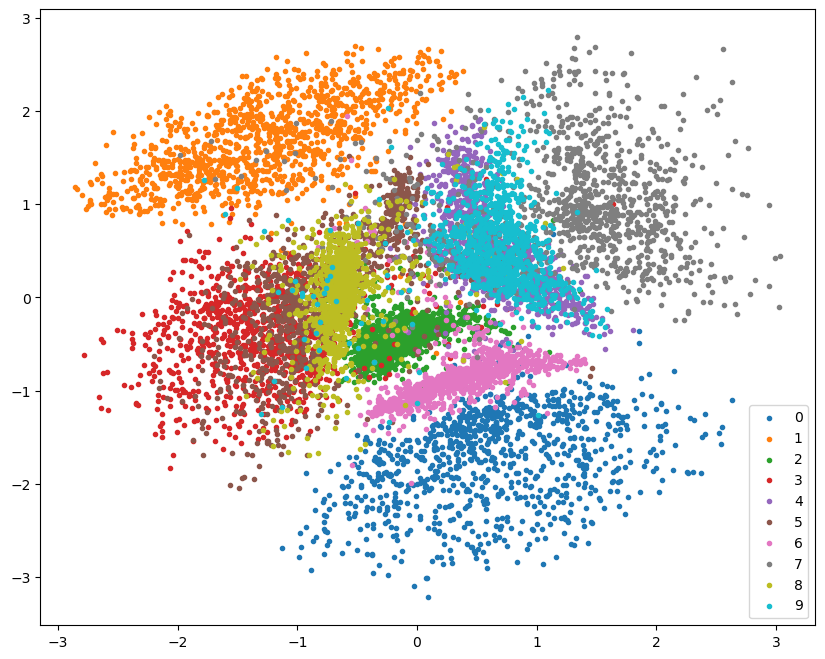

In [ ]:
plt.figure(figsize=(10, 8))

for label in range(10):
    points = df[df["label"] == label]
    plt.scatter(points["x"], points["y"], label=label, marker=".")

plt.legend();

Let's compare decoding using AE and VAE

In [ ]:
z = torch.normal(0, 1, size=(10, 2))
with torch.inference_mode():
    ae_decoded = ae_model.decode(z.to(device))
    vae_decoded = vae_model.decode(z.to(device))

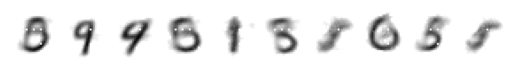

In [ ]:
display_images(ae_decoded.cpu())

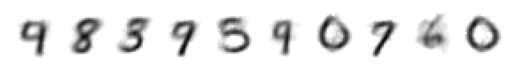

In [ ]:
display_images(vae_decoded.cpu())

Let's decode from the VAE along a vertical line

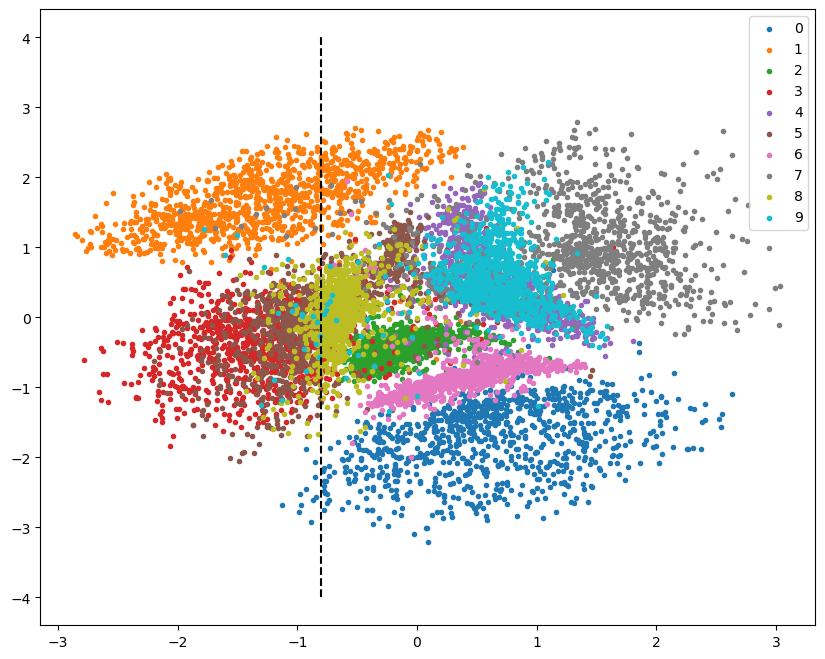

In [ ]:
plt.figure(figsize=(10, 8))

for label in range(10):
    points = df[df["label"] == label]
    plt.scatter(points["x"], points["y"], label=label, marker=".")

plt.vlines(-0.8, ymin=-4, ymax=4, linestyle="dashed", colors="black")
plt.legend();

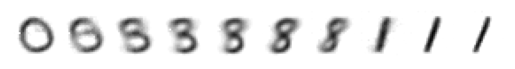

In [ ]:
with torch.inference_mode():
    inputs = []
    for y in np.linspace(-2, 2, 10):
        inputs.append([-0.8, y])
    z = torch.tensor(inputs, dtype=torch.float32).to(device)
    decoded = vae_model.decode(z)
display_images(decoded.cpu())


In [ ]:
Another vertical line at x=0.8

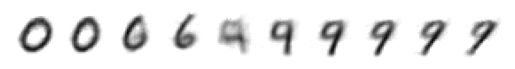

In [ ]:
with torch.inference_mode():
    inputs = []
    for y in np.linspace(-2, 2, 10):
        inputs.append([0.8, y])
    z = torch.tensor(inputs, dtype=torch.float32).to(device)
    decoded = vae_model.decode(z)
display_images(decoded.cpu())
